## 0. Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/UChicago🏫/ML Final Project 2025"

 BMI.zip				  'ML Final - VGG model'
'ML2 Final Project - Task Split up.gdoc'   Untitled0.ipynb


In [3]:
!mkdir -p /content/data
!unzip "/content/drive/MyDrive/UChicago🏫/ML Final Project 2025/BMI.zip" -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/BMI/Data/Images/img_4108.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_4108.bmp  
  inflating: /content/data/BMI/Data/Images/img_3667.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_3667.bmp  
  inflating: /content/data/BMI/Data/Images/img_2790.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2790.bmp  
  inflating: /content/data/BMI/Data/Images/img_279.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_279.bmp  
  inflating: /content/data/BMI/Data/Images/img_2948.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2948.bmp  
  inflating: /content/data/BMI/Data/Images/img_1299.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_1299.bmp  
  inflating: /content/data/BMI/Data/Images/img_2784.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2784.bmp  
  inflating: /content/data/BMI/Data/Images/img_523.bmp  
  inf

In [4]:
!ls /content/data/BMI/Data

data.csv  Images


In [5]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
DATA_DIR = '/content/data/BMI/Data'

csv_path = os.path.join(DATA_DIR, 'data.csv')
labels = pd.read_csv(csv_path)
print("Columns:", labels.columns.tolist())
labels.head()

Columns: ['Unnamed: 0', 'bmi', 'gender', 'is_training', 'name']


,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


## 1. Import

In [23]:
# !pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [10]:
import os
import torch
import numpy as np
import pandas as pd
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from math import sqrt
import matplotlib.pyplot as plt

## 2. Modeling - FaceNet (InceptionResnetV1 pretrained on VGGFace2)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [13]:
preprocess = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [14]:
def extract_facenet(img_path):
    img = Image.open(img_path).convert('RGB')
    x   = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(x)            # (1,512)
    return emb.cpu().numpy().reshape(-1)

def batch_extract_facenet(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for fn in os.listdir(input_dir):
        if not fn.lower().endswith(('.jpg','.png','.jpeg','.bmp')):
            continue
        stem = os.path.splitext(fn)[0]
        emb  = extract_facenet(os.path.join(input_dir, fn))
        np.save(os.path.join(output_dir, stem + '.npy'), emb)
    print(f"✅ Done extracting to '{output_dir}'")

In [15]:
def svr_regression(features_dir, data_csv):
    df = pd.read_csv(data_csv)
    X_train, X_test, y_train, y_test = [], [], [], []
    missing = []
    for _, row in df.iterrows():
        stem = os.path.splitext(row['name'])[0]
        path = os.path.join(features_dir, stem + '.npy')
        if not os.path.isfile(path):
            missing.append(stem)
            continue
        feat = np.load(path)
        if row['is_training'] == 1:
            X_train.append(feat); y_train.append(row['bmi'])
        else:
            X_test.append(feat);  y_test.append(row['bmi'])
    if missing:
        print(f"⚠️ Missed {len(missing)} samples, e.g. {missing[:5]}")
    X_train = np.vstack(X_train); X_test = np.vstack(X_test)
    y_train = np.array(y_train); y_test = np.array(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    param_grid = {'C':[0.1,1,10],'epsilon':[0.1,0.2,0.5],'kernel':['linear','rbf']}
    grid = GridSearchCV(SVR(), param_grid, cv=5,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1, verbose=2)
    grid.fit(X_train_scaled, y_train)
    best = grid.best_estimator_
    print("Best params:", grid.best_params_)

    y_pred = best.predict(X_test_scaled)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    print(f"RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}, Pearson r={r:.3f}")

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    m, M = y_test.min(), y_test.max()
    plt.plot([m,M],[m,M],'k--')
    plt.xlabel("Actual BMI"); plt.ylabel("Predicted BMI")
    plt.title("Facenet Features + SVR")
    plt.show()

✅ Done extracting to '/content/data/Features_facenet'
⚠️ Missed 244 samples, e.g. ['img_4', 'img_5', 'img_40', 'img_86', 'img_93']
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
RMSE=7.168, MAE=5.110, R²=0.395, Pearson r=0.637


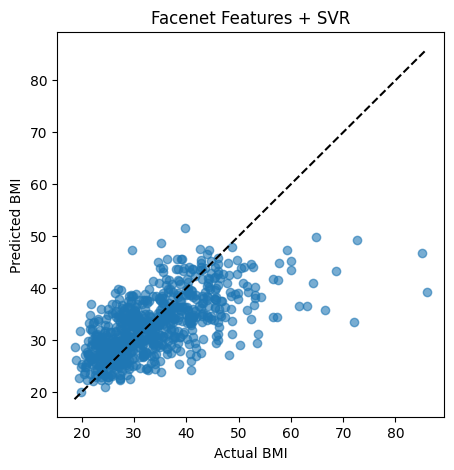

In [16]:
if __name__ == "__main__":
    input_dir    = "/content/data/BMI/Data/Images"
    features_dir = "/content/data/Features_facenet"
    data_csv     = "/content/data/BMI/Data/data.csv"

    batch_extract_facenet(input_dir, features_dir)
    svr_regression(features_dir, data_csv)

In [17]:
def svr_regression_by_gender(features_dir, data_csv):

    df = pd.read_csv(data_csv)
    X_train, X_test = [], []
    y_train, y_test = [], []
    gender_test = []
    missing = []

    for _, row in df.iterrows():
        stem = os.path.splitext(row['name'])[0]
        feat_path = os.path.join(features_dir, stem + '.npy')
        if not os.path.isfile(feat_path):
            missing.append(stem)
            continue

        feat = np.load(feat_path)
        if row['is_training'] == 1:
            X_train.append(feat); y_train.append(row['bmi'])
        else:
            X_test.append(feat);
            y_test.append(row['bmi'])
            gender_test.append(row['gender'])

    if missing:
        print(f"⚠️ Warning: Missed {len(missing)} samples")

    X_train = np.vstack(X_train)
    X_test  = np.vstack(X_test)
    y_train = np.array(y_train)
    y_test  = np.array(y_test)

    # Feature Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # SVR
    param_grid = {'C':[0.1,1,10], 'epsilon':[0.1,0.2,0.5], 'kernel':['linear','rbf']}
    grid = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error',
                        n_jobs=-1, verbose=2)
    grid.fit(X_train_scaled, y_train)
    best_svr = grid.best_estimator_
    print("Best SVR params:", grid.best_params_)

    # Prediction
    y_pred = best_svr.predict(X_test_scaled)

    eval_df = pd.DataFrame({
        'gender': gender_test,
        'actual': y_test,
        'pred':   y_pred
    })
    for g in ['Male','Female']:
        grp = eval_df[eval_df['gender']==g]
        if grp.empty:
            print(f"⚠️ No samples for gender={g}")
            continue

        rmse = sqrt(mean_squared_error(grp.actual, grp.pred))
        mae  = mean_absolute_error(grp.actual, grp.pred)
        r2   = r2_score(grp.actual, grp.pred)
        r, _ = pearsonr(grp.actual, grp.pred)

        print(f"{g} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}, Pearson r: {r:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.3, label='All')

    for g, color in [('Male','C0'),('Female','C1')]:
        grp = eval_df[eval_df['gender']==g]
        plt.scatter(grp.actual, grp.pred, alpha=0.6, c=color, label=g)
    m, M = y_test.min(), y_test.max()
    plt.plot([m,M],[m,M],'k--', lw=1)
    plt.xlabel("Actual BMI"); plt.ylabel("Predicted BMI")
    plt.legend()
    plt.title("SVR Prediction by Gender")
    plt.tight_layout()
    plt.show()

⚠️ Warning: 找不到 244 个特征文件，示例：['img_4', 'img_5', 'img_40', 'img_86', 'img_93']
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVR params: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
Male -> RMSE: 7.073, MAE: 5.100, R²: 0.379, Pearson r: 0.635
Female -> RMSE: 7.291, MAE: 5.122, R²: 0.410, Pearson r: 0.648


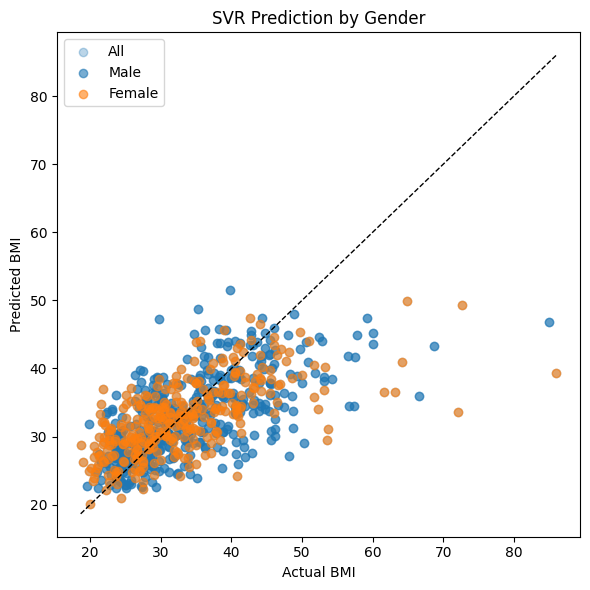

In [18]:
features_dir = "/content/data/Features_facenet"
data_csv     = "/content/data/BMI/Data/data.csv"

svr_regression_by_gender(features_dir, data_csv)